In [204]:
import numpy as np
from pandas.core.frame import DataFrame
import forces
from scipy.integrate import odeint
from scipy.stats import maxwell 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

<h2 style="color:orange">Function to create N randomized particles</h2>

In [147]:
par = {
            'l': 40,
            'x_r': 39.107,            
            'Rr': 5.6e-5, 
            'Rp':7.5e-7,
            'R_ratio':0,
            'n_w': 1.326,
            'n_p': 1.572
            }

In [198]:
lambd = 2*np.pi*par['Rr']/par['x_r']       #lamb = 2*pi / k where k = x/Rr
M = (4/3) * np.pi * (par['Rp']**3) *1040   #where density of silica is 1040
tao = 0.00048528                           #value obtained from mathematica
kbt = 1.38064852e-23 * 300                 #value is in eV
alpha = 7.02158e-14
stdevTildaV = (4*kbt*(par['Rr']**3))/(3*(2.92291e-8)*(par['Rp']**3)*lambd)
vavgTilda = np.sqrt(stdevTildaV)

eta = (0.00700175*M)/(vavgTilda*6*np.pi*(par['Rp'])*tao)#Eta is for Average Rp and Average velocity for all cartesian directions

In [149]:
def randomized(N):
    Results = pd.DataFrame(columns=['rand_x','rand_y','rand_z','rho_','theta_','phi_','dRho_','dTheta_','dPhi_','Rp_','gamma_','time_'])
    while Results.count()[0] != N:
        Rp = np.random.uniform(7.5*10**(-7) - 3.75*10**(-8), 7.5*10**(-7) + 3.75*10**(-8))
        #random positions
        rho = np.random.uniform(39.107,39.107+(2*np.pi))
        theta = np.random.uniform(((np.pi/2)-np.sqrt(1/40)),((np.pi/2)+np.sqrt(1/40)))
        phi = np.random.uniform(0,np.pi*2)
        #random velocities
        vx = np.random.normal(0,stdevTildaV)
        vy = np.random.normal(0,stdevTildaV)
        vz = np.random.normal(0,stdevTildaV)
        #rhop is density, 

        m = (4/3) * np.pi * (Rp**3) *1040
        gamma = (6 * np.pi * eta * tao * Rp)/m #gamma tilde, average tao not sepcific to size
    
        dRhodT = vx*np.sin(theta)*np.cos(phi)+vy*np.sin(theta)*np.sin(phi)+vz*np.cos(theta) #vrho 
        if dRhodT <= 0: #try more numbers forward trajectory of one of the particles 
            Results = pd.concat([pd.DataFrame([[vx,  vy,  vz,  rho,  theta,  phi, dRhodT,0,0,Rp,gamma,None]],columns = Results.columns),Results],ignore_index = True)
    
    return Results

In [197]:
def rand(N):
    Results = pd.DataFrame(columns=['rand_x','rand_y','rand_z','rho_','theta_','phi_','dRho_','dTheta_','dPhi_','Rp_','gamma_','time_'])
    Rpi = np.linspace(7.5*10**(-7)- 3.75*10**(-8), 7.5*10**(-7) + 3.75*10**(-8), N)
    Rpi = np.array(Rpi)
    m = (4/3) * np.pi * (Rpi**3) *1040
    gamma = (6 * np.pi * eta * tao * Rpi)/m #gamma tilde, average tao not sepcific to size
    while Results.count()[0] != N:
        Results = pd.concat([pd.DataFrame([[-0.001421,  0.006615,  0.001120,  39.351469,  1.654382,  4.081736, -0.004582,0,0,None,None,None]],columns = Results.columns),Results],ignore_index = True)
    Results['Rp_'] = Rpi
    Results['gamma_'] = gamma
    return Results

<h2 style="color:deeppink">ODE Solver Function</h2>

In [199]:
TC = []
def f(u, t, par, gamma,Rp):
        rho, drho, theta, dtheta, phi, dphi = u
        dudt = [
                drho, forces.rho(rho, theta, par) - gamma * drho + rho * (dtheta * np.cos(phi)) ** 2 + rho * dphi ** 2,
                dtheta, (forces.theta(rho, theta, par) - gamma * rho * dtheta * np.cos(phi) - 2 * drho * dtheta * np.cos(phi) + 2 * rho * dtheta * dphi * np.sin(phi)) / (rho * np.cos(phi)),
                dphi, (forces.phi(rho, theta, par) - gamma * rho * dphi - 2 * drho * dphi - rho * dphi ** 2 * np.sin(phi) * np.cos(phi)) / rho
            ]
        if rho <= 39.107+Rp: #and theta <= (np.pi/2 + 0.01) and theta >= (np.pi - 0.01):
            TC.append(t)
            return [None,None,None,None,None,None]
        return dudt

<span style="color:red">Automates solution for multiple particles</span>

In [250]:

def solve(Results):
    global TC
    j = 0
    time = np.linspace(0,20,900000000000)
    while j != len(Results.index):
        gamma_ = Results['gamma_'][j]
        Rp_ = Results['Rp_'][j]
        par['R_ratio'] = (Results['Rp_'][j])/(5.6*10**(-5))  
        u0 = [Results['rho_'][j],Results['dRho_'][j], Results['theta_'][j], Results['dTheta_'][j], Results['phi_'][j], Results['dPhi_'][j]]
        sol = odeint(f, u0, time, args = (par, gamma_,Rp_))
        if len(TC) != 0:
            Results.at[j,'time_'] = TC[0]
            TC = []
        j+=1
    return Results


<span style="color:red">Call to functions</span>

In [251]:
h = pd.DataFrame(columns=['rand_x', 'rand_y', 'rand_z', 'rho_', 'theta_', 'phi_', 'dRho_',
       'dTheta_', 'dPhi_', 'Rp_', 'gamma_', 'time_'])

F = rand(50)

z = solve(F)
h = pd.concat([z, h],ignore_index = True)



In [ ]:
3+3

Error: Session cannot generate requests

<span style="color:red">Test case of where discontinuity exists and disappears when linspace of time is increased</span>

In [246]:
TC = []
time0 = np.linspace(0,20,50000)
u0 = [39.351469,-0.004582 , 1.654382, 0, 4.081736, 0] 

par['R_ratio'] = (7.247449e-07)/(5.6*10**(-5)) 
gamma_1 = 0.080198 
sol1 = odeint(f, u0, time0, args = (par, gamma_1, 7.247449e-07))
print(TC[0])
TC = []

par['R_ratio'] = (7.232143e-07)/(5.6*10**(-5)) 
gamma_2 = 0.080537
sol2 = odeint(f, u0, time0, args = (par, gamma_2, 7.232143e-07))
print(TC[0])

9.801497905570116
9.802202178457193


<h1 style="color:lime">Time vs. Rp for 50 particles</h1>

In [ ]:
plt.plot(h['Rp_'],h['time_'],"o")
plt.xlabel('Rp')
plt.ylabel('Time')
plt.show()

Error: Session cannot generate requests

<h2 style="color:green">Individual Trajectories</h2>

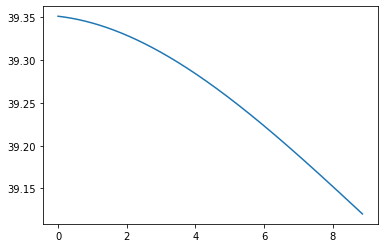

In [157]:


plt.plot(time0, sol1[:,0], "-") 
#plt.plot(time0, sol2[:,0], color = "red")
plt.show()
